### Task
1.  Determine 5 most common journals
    1. Find total articles for each
2.  Calculate mean, median, std dev of open access cost per article for each journal
3.  Bonus Round:  identify open access prices paid by subj area

#### Import libraries and data

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import re
import string

In [2]:
df = pd.read_csv('WELLCOME_APCspend2013_forThinkful.csv', encoding = 'Latin-1')

In [3]:
df.describe()

,PMID/PMCID,Publisher,Journal title,Article title,COST (£) charged to Wellcome (inc VAT when charged)
count,1928,2127,2126,2127,2127
unique,1880,299,984,2126,1402
top,Not yet available,Elsevier,PLoS One,"Exclusive breastfeeding, diarrhoel morbidity a...",£2040.00
freq,7,387,92,2,94


In [4]:
df.head()

,PMID/PMCID,Publisher,Journal title,Article title,COST (£) charged to Wellcome (inc VAT when charged)
0,NaN,CUP,Psychological Medicine,Reduced parahippocampal cortical thickness in ...,£0.00
1,PMC3679557,ACS,Biomacromolecules,Structural characterization of a Model Gram-ne...,£2381.04
2,23043264 PMC3506128,ACS,J Med Chem,"Fumaroylamino-4,5-epoxymorphinans and related ...",£642.56
3,23438330 PMC3646402,ACS,J Med Chem,Orvinols with mixed kappa/mu opioid receptor a...,£669.64
4,23438216 PMC3601604,ACS,J Org Chem,Regioselective opening of myo-inositol orthoes...,£685.88


#### Missing Info
About 10% missing from PMID/PMCID column.  But we are mostly concerned with the journal titles, article titles, and cost.  Of these, only one 0.05% (1 journal title) is missing.  

In [5]:
for col in df.columns:
    print('{}:  {}'.format(col, df[col].isnull().sum()/df[col].shape[0]*100))

PMID/PMCID:  9.35590032910202
Publisher:  0.0
Journal title:  0.04701457451810061
Article title:  0.0
COST (£) charged to Wellcome (inc VAT when charged):  0.0


### Determine 5 most common journals

From the raw data, there are ~985 unique journal titles.  But looking at the first 10 journal titles in alphabetical order, we see that ACS NANO and ACS Nano are the same journal, but categorized as different titles.  A similar situation arises with PLoS One and PLoS ONE, seen below in the top 15 most common journals as seen in the raw data.  An easy way to fix this is to make all letters lowercase and strip the white space.  Other small things to decrease repeated journals is to remove punctuation, convert '&' to 'and', and convert '1' to 'one'.
 

In [6]:
df['Journal title'].nunique()

984

In [7]:
sorted(df[df['Journal title'].notnull()]['Journal title'].unique())[:10]

['ACS Chemical Biology',
 'ACS Chemical Neuroscience',
 'ACS NANO',
 'ACS Nano',
 'ACTA F',
 'AGE',
 'AIDS',
 'AIDS Behav',
 'AIDS Care',
 'AIDS Journal']

In [8]:
df['Journal title'].value_counts()[:15]

PLoS One                                           92
PLoS ONE                                           62
Journal of Biological Chemistry                    48
Nucleic Acids Research                             21
Proceedings of the National Academy of Sciences    19
Human Molecular Genetics                           18
PLoS Neglected Tropical Diseases                   18
Nature Communications                              17
PLoS Pathogens                                     15
Neuroimage                                         15
PLoS Genetics                                      15
PLOS ONE                                           14
NeuroImage                                         14
BMC Public Health                                  14
Brain                                              14
Name: Journal title, dtype: int64

In [9]:
def initial_conversion(col):
# Convert string to lower case and remove white space
# Convert '&' to 'and'
# Convert '1', to 'one
# Remove punctuation
    try:
        col = col.lower().strip()
        col = col.replace('&', 'and')
        col = col.replace('1', 'one')
        col = col.translate(str.maketrans('', '', string.punctuation))
        return col
    except AttributeError:
        pass

In [10]:
df['Journal title'] = df['Journal title'].apply(initial_conversion)

In [11]:
df['Journal title'].nunique()

876

Purely converting all titles to lowercase and stripping of white space reduces the number of unique journals by ~100.  The other manipulations decreased the count by 10.  

Below I've looked at the top 15 most common journal titles to see where to concentrate most of my efforts to find the 5 most common journals.  

In [12]:
df['Journal title'].value_counts()[:15]

plos one                                           197
journal of biological chemistry                     53
neuroimage                                          29
nucleic acids research                              26
plos genetics                                       24
plos pathogens                                      24
proceedings of the national academy of sciences     22
plos neglected tropical diseases                    20
nature communications                               19
human molecular genetics                            19
movement disorders                                  15
brain                                               14
bmc public health                                   14
journal of neuroscience                             13
developmental cell                                  12
Name: Journal title, dtype: int64

#### Plos one
Plos one is by far the most popular journal so far.  plos is a pretty unique spelling, so lets see if we can find other variations of plos one.

In [13]:
for j in df[df['Journal title'].notnull()]['Journal title'].unique():
    if 'plos' in j:
        print(j)

plos computational biology
plos genetics
plos ntd
plos one
plos pathogens
plos
plos  computational biology
plos  one
plos biology
plos medicine
plos medicine journal
plos negected tropical diseases
plos neglected tropical diseases
plosone


From the above list, I see 'plosone' and 'plos  one'.  Fixing these typos increases the number from 197 to 207.  

In [14]:
def fix_plos_one(col):
    try:
        if col == 'plosone':
            return 'plos one'
        elif col == 'plos  one':
            return 'plos one' 
        else:
            return col
    except AttributeError:
        pass

In [15]:
df['Journal title'] = df['Journal title'].apply(fix_plos_one)

#### Journal of biological chemistry
Biology, bio, chem, and biochem are all very common phrases.  I had to go through the alphabetized list by eye to pick out the following variations.  Fixing these variations increased the number from 52 to 59.

*List of journal of biological chemistry abbreviations:*  
'j biol chem.'  
'j biol chemistry'  
'jnl biological chemistry'  
'journal biological chemistry'   
'journal of biological chemistry'  
'journal of biol chem'  
'journal of biological chemistry'  

In [16]:
def fix_bio_chem(col):
    try:
        if col == 'j biol chem.':
            return 'journal of biological chemistry'
        elif col == 'j biol chemistry':
            return 'journal of biological chemistry'
        elif col == 'jnl biological chemistry':
            return 'journal of biological chemistry'
        elif col == 'journal biological chemistry':
            return 'journal of biological chemistry'
        elif col == 'journal of biol chem':
            return 'journal of biological chemistry'
        else:
            return col
    except AttributeError:
        pass

In [17]:
df['Journal title'] = df['Journal title'].apply(fix_bio_chem)

#### Nucleic acid research
I only found one misspelling of 'nucleic acid research'.  Fixing this increased the count from 26 to 29.  

In [18]:
for j in df[df['Journal title'].notnull()]['Journal title'].unique():
    if 'nucleic' in j:
        print(j)

nucleic acids research
nucleic acid research


In [19]:
def fix_nar(col):
    try:
        if col == 'nucleic acid research':
            return 'nucleic acids research'
        else:
            return col
    except AttributeError:
        pass

In [20]:
df['Journal title'] = df['Journal title'].apply(fix_nar)

#### Proceedings of the national academy of sciences
This is another one that required scanning by eye to find all the variations, which is listed as follows:

*List of Proceedings of the national academy of sciences abbreviations:*  
'pnas'  
'pnas (proceedings of the national academy of sciences of the united states of america'  
'pnas usa'  
'proc natl acad sci u s a.'  
'proceddings of the national academy of sciences of usa'  
'proceedings of the national academy of sciences'  
'proceedings of the national academy of sciences (pnas)'  
'proceedings of the national academy of sciences of the united states of america'  
'proceedings of the national academy of sciences of the usa'  


Fixing these abbreviations increased the number from 22 to 34.  

In [22]:
def fix_pnas(col):
    try:
        if col == 'pnas':
            return 'proceedings of the national academy of sciences'
        elif col == 'pnas (proceedings of the national academy of sciences of the united states of america':
            return 'proceedings of the national academy of sciences'
        elif col == 'pnas usa':
            return 'proceedings of the national academy of sciences'
        elif col == 'proc natl acad sci u s a.':
            return 'proceedings of the national academy of sciences'
        elif col == 'proceddings of the national academy of sciences of usa':
            return 'proceedings of the national academy of sciences'
        elif col == 'proceedings of the national academy of sciences (pnas)':
            return 'proceedings of the national academy of sciences'
        elif col == 'proceedings of the national academy of sciences of the united states of america':
            return 'proceedings of the national academy of sciences'
        elif col == 'proceedings of the national academy of sciences of the usa':
            return 'proceedings of the national academy of sciences'
        else:
            return col
    except AttributeError:
        pass

In [23]:
df['Journal title'] = df['Journal title'].apply(fix_pnas)

#### Answer:
top 5 journals are:  

In [26]:
df['Journal title'].value_counts()[:5]

plos one                                           207
journal of biological chemistry                     59
proceedings of the national academy of sciences     34
neuroimage                                          29
nucleic acids research                              29
Name: Journal title, dtype: int64

As expected, plos one by far was the most frequent journal with almost 200 articles.  The next most frequent journal was the Journal of Biological Chemistry, which had ~70 articles.  The rest were between 25 and 35 articles.  

In [49]:
top_five = df[(df['Journal title'] == df['Journal title'].value_counts()[:1].index[0]) | 
  (df['Journal title'] == df['Journal title'].value_counts()[1:2].index[0]) |
  (df['Journal title'] == df['Journal title'].value_counts()[2:3].index[0]) |
  (df['Journal title'] == df['Journal title'].value_counts()[3:4].index[0]) |
  (df['Journal title'] == df['Journal title'].value_counts()[4:5].index[0]) ]

In [50]:
answer1 = pd.DataFrame()
answer1['Journal title'] = top_five['Journal title'].value_counts().index
answer1['Title count'] = top_five['Journal title'].value_counts().values

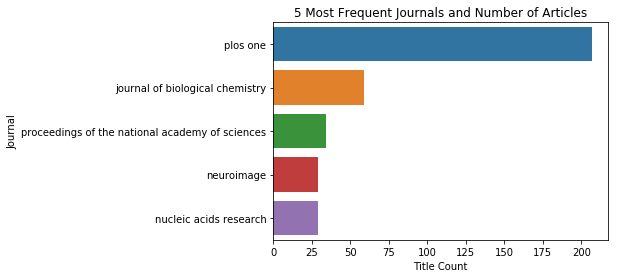

In [51]:
sns.barplot(x = 'Title count', y = 'Journal title',  data = answer1)
plt.title('5 Most Frequent Journals and Number of Articles')
plt.ylabel('Journal')
plt.xlabel('Title Count')

### Mean, Median, Std Dev of Cost for per article for each journal
To find the cost per article, I had to do some string manipulation because there is a '£' symbol.  Then, to plot it in a histogram, I needed to convert it to a float.

In [53]:
# Remove '£' symbol and convert to float
top_five['COST (£) charged to Wellcome (inc VAT when charged)'] = top_five['COST (£) charged to Wellcome (inc VAT when charged)'].apply(lambda x:  float(x[1:]))

C:\Users\Crystal\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


Below are the histograms of the costs.  On the left is the cost distribution for all articles.  As you can see, some of the prices get ridiculously high, at 1 million pounds.  To the right is a cost distribution for all articles under £25000.  As you can see, the highest cost in this figure is ~£3000, so there aren't any articles that cost between £3000 and £25000.  From this plot, we can see that most of the articles cost ~£800. 

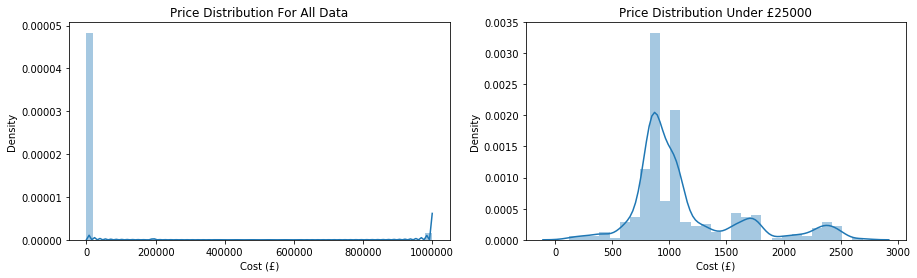

In [55]:
fig, (axis1, axis2) = plt.subplots(1,2,figsize=(15,4))

sns.distplot(top_five['COST (£) charged to Wellcome (inc VAT when charged)'], ax = axis1)
sns.distplot(top_five[top_five['COST (£) charged to Wellcome (inc VAT when charged)'] < 25000]['COST (£) charged to Wellcome (inc VAT when charged)'], ax = axis2)

axis1.set_title('Price Distribution For All Data')
axis2.set_title('Price Distribution Under £25000')

for ax in [axis1, axis2]:
    ax.set_xlabel('Cost (£)')
    ax.set_ylabel('Density')

Instead of removing these outlier prices, I'll try a 90% winsorization on them.  The data now ranges between £600 and £2500.

In [56]:
import scipy.stats

In [57]:
top_five['COST (£) charged to Wellcome (inc VAT when charged)'] = scipy.stats.mstats.winsorize(top_five['COST (£) charged to Wellcome (inc VAT when charged)'], limits = [0.05, 0.05])

C:\Users\Crystal\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


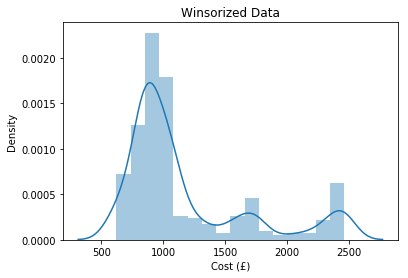

In [59]:
sns.distplot(top_five['COST (£) charged to Wellcome (inc VAT when charged)'])
plt.title('Winsorized Data')
plt.xlabel('Cost (£)')
plt.ylabel('Density')

I can now find the mean, median, and standard deviations per article for each journal, seen below.

In [60]:
plos_one_mean = top_five[top_five['Journal title'] == 'plos one']['COST (£) charged to Wellcome (inc VAT when charged)'].mean()
plos_one_median = top_five[top_five['Journal title'] == 'plos one']['COST (£) charged to Wellcome (inc VAT when charged)'].median()
plos_one_std = top_five[top_five['Journal title'] == 'plos one']['COST (£) charged to Wellcome (inc VAT when charged)'].std()

In [61]:
jbc_mean = top_five[top_five['Journal title'] == 'journal of biological chemistry']['COST (£) charged to Wellcome (inc VAT when charged)'].mean()
jbc_median = top_five[top_five['Journal title'] == 'journal of biological chemistry']['COST (£) charged to Wellcome (inc VAT when charged)'].median()
jbc_std = top_five[top_five['Journal title'] == 'journal of biological chemistry']['COST (£) charged to Wellcome (inc VAT when charged)'].std()

In [62]:
pnas_mean = top_five[top_five['Journal title'] == 'proceedings of the national academy of sciences']['COST (£) charged to Wellcome (inc VAT when charged)'].mean()
pnas_median = top_five[top_five['Journal title'] == 'proceedings of the national academy of sciences']['COST (£) charged to Wellcome (inc VAT when charged)'].median()
pnas_std = top_five[top_five['Journal title'] == 'proceedings of the national academy of sciences']['COST (£) charged to Wellcome (inc VAT when charged)'].std()

In [63]:
neural_mean = top_five[top_five['Journal title'] == 'neuroimage']['COST (£) charged to Wellcome (inc VAT when charged)'].mean()
neural_median = top_five[top_five['Journal title'] == 'neuroimage']['COST (£) charged to Wellcome (inc VAT when charged)'].median()
neural_std = top_five[top_five['Journal title'] == 'neuroimage']['COST (£) charged to Wellcome (inc VAT when charged)'].std()

In [64]:
nar_mean = top_five[top_five['Journal title'] == 'nucleic acids research']['COST (£) charged to Wellcome (inc VAT when charged)'].mean()
nar_median = top_five[top_five['Journal title'] == 'nucleic acids research']['COST (£) charged to Wellcome (inc VAT when charged)'].median()
nar_std = top_five[top_five['Journal title'] == 'nucleic acids research']['COST (£) charged to Wellcome (inc VAT when charged)'].std()

In [67]:
top_five_stats = pd.DataFrame(np.array([[plos_one_mean, plos_one_median, plos_one_std], 
                                      [jbc_mean, jbc_median, jbc_std],
                                      [pnas_mean, pnas_median, pnas_std],
                                      [neural_mean, neural_median, neural_std], 
                                      [nar_mean, nar_median, nar_std]]), 
                             columns = ['Mean', 'Median', 'Standard Deviation'],
                             index = ['plos one', 'journal of biological chemistry','pnas', 'neuralimage', 'nucleic acids research'])

In [68]:
top_five_stats

,Mean,Median,Standard Deviation
plos one,1010.648116,899.340,352.534855
journal of biological chemistry,1428.166949,1287.750,440.153896
pnas,835.172059,728.825,435.344194
neuralimage,2212.011034,2326.430,263.328930
nucleic acids research,1162.344828,852.000,442.150934


Here, we see the journal with the cheapest per article is from pnas, with a mean at ~£835.  The most expensive (and with the lowest standard deviation) is from neuralimage, with a mean of ~£2200.  

### Bonus Round: identify open access prices paid by subject area
I've chosen to not do the bonus round for now.  Next time...